# Instalation

In [1]:
try:
  !pip install torchinfo
except:
  print("torchinfo alredy installeed")

# Imports


In [2]:
import os
import torch
import torchvision
import numpy as np
from pathlib import Path
from torch import nn
from torchvision import datasets, transforms
import requests
import zipfile
import matplotlib.pyplot as plt
import random
from PIL import Image
from torch.utils.data import DataLoader
from typing import Tuple, Dict, List
import torchinfo
from torchinfo import summary
from IPython.testing import test
from torch.nn.modules.activation import ReLU
from torch.nn.modules.pooling import MaxPool1d
from torch.nn.modules.conv import Conv2d
from torchvision.datasets.imagenet import ImageFolder
from timeit import default_timer as timer
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

#   Functions

In [3]:
def plot_transformed_images(image_paths: list, transform, n = 3, seed = None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(transformed_image.shape)
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 8,
                          display_shape: bool = True,
                          seed: int = None):
  if n > 8:
    n = 10
    display_shape = False
    # it is beter to have max 10 images
  if seed:
    random.seed(seed)

  plt.figure(figsize = (32,8))


  random_sample_idx = random.sample(range(len(dataset)), k = n)
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_img_adjust = targ_image.permute(1,2,0)

    plt.subplot(1,n, i+1)
    plt.imshow(targ_img_adjust)
    plt.axis(False)
    if classes:
      title = f"classes: {classes[targ_label]}"
      if display_shape:
        title = title + f"\n Shape of img: {targ_img_adjust.shape}"
    plt.title(title)


def train_time(start:float,
               end:float,
               device: torch.device = None):
  """Prints difference between start and end"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} s")
  return total_time



def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']


    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

def evaluate_img(model:nn.Module,
                 root_path:Path,
                 class_names,
                 device,
                 x:int = 128,
                 y:int = 128

                 ):
  """This Function evaluate a plot the given image with given model"""

  model.eval()

  path_list = list(root_path.glob("*.jpg"))


  for image_path in path_list:

    plt.figure(figsize=(15,7))

    img = torchvision.io.read_image(str(image_path)).to(device) / 255

    img_trans = transforms.Compose([transforms.Resize(size=(x,y))])
    img_trans_final = transforms.Compose([transforms.Resize(size=(512,512))])

    transformed_img = img_trans(img)

    with torch.inference_mode():
      img_preds = model(transformed_img.unsqueeze(0).to(device))

    img_label = img_preds.argmax(1)

    plt.imshow(img_trans_final(img).cpu().permute(1,2,0))
    plt.title(f"Pred: {class_names[img_label]}")

    plt.axis(False);




# Code

## Datasets

In [4]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

image_path_list = list(image_path.glob("*/*/*.jpg"))

if image_path.is_dir():
  print("Flie exist")
else:
  image_path.mkdir(parents= True, exist_ok = True)

In [5]:
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
  print("Downloading..")
  f.write(request.content)

Downloading..


In [6]:
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
  print("Unziping")
  zip_ref.extractall(image_path)

Unziping


In [7]:
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading..")
  f.write(request.content)



Downloading..


In [8]:
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
  print("Unziping")
  zip_ref.extractall("data/pizza_steak_sushi_20_percent")

Unziping


In [9]:
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"
train_dir_20 = "data/pizza_steak_sushi_20_percent/train"
test_dir_20 = "data/pizza_steak_sushi_20_percent/test"

In [10]:
train_data_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.RandAugment(num_magnitude_bins=41),
    #transforms.TrivialAugmentWide(num_magnitude_bins=1),
    # Turn image into torch tensor
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size = (128,128)),
    transforms.ToTensor()])



In [11]:
#plot_transformed_images(image_path_list, train_data_transform, 8)

450
450
450
<torch.utils.data.dataset.ConcatDataset object at 0x7b8431057c50> 1350 450


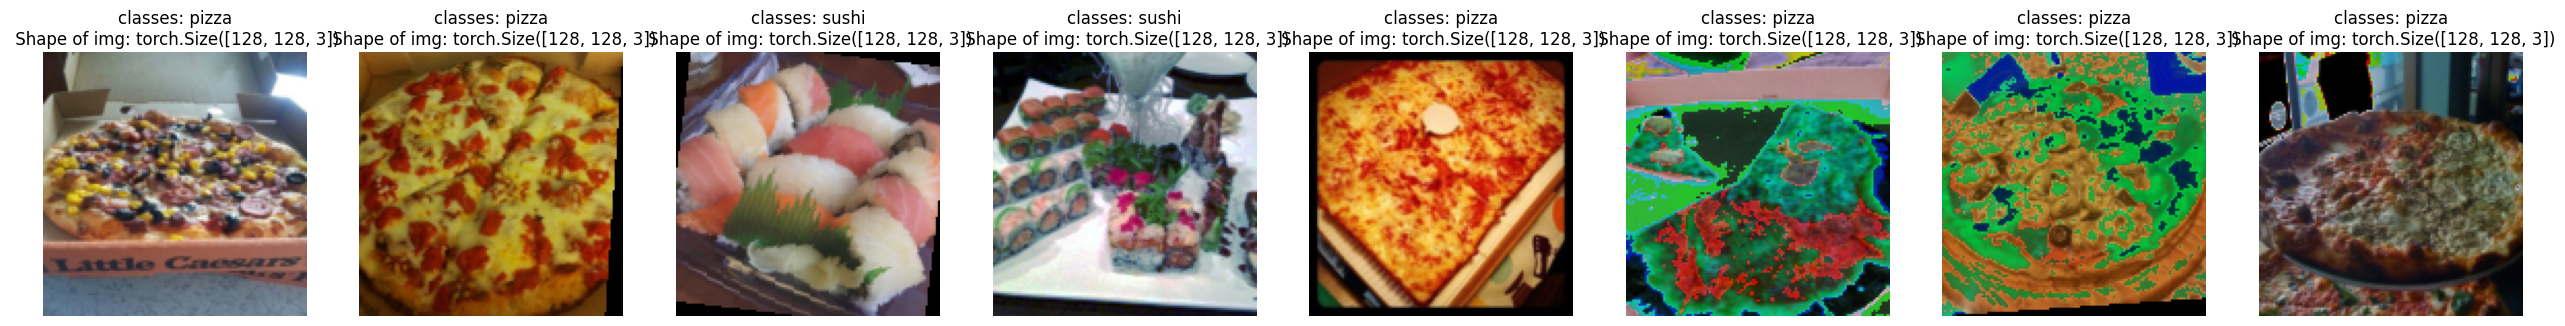

In [12]:
from torch.utils.data import dataloader
train_dataset = datasets.ImageFolder(root = train_dir,
                                     transform = train_data_transform,
                                     target_transform= None)
print(len(train_dataset))
test_dataset = datasets.ImageFolder(root = test_dir,
                                    transform = test_data_transform)

train_dataset_2 = datasets.ImageFolder(root = train_dir,
                                       transform= test_data_transform
                                      )
print(len(train_dataset_2))
train_dataset_20 = datasets.ImageFolder(root = train_dir_20,
                                     transform = train_data_transform,
                                     target_transform= None)
print(len(train_dataset_20))
test_dataset_20 = datasets.ImageFolder(root = test_dir_20,
                                    transform = test_data_transform)


class_names = train_dataset.classes
class_dict = train_dataset.class_to_idx

train_dataset = train_dataset + train_dataset_2 + train_dataset_20
test_dataset = test_dataset + test_dataset_20
print(train_dataset, len(train_dataset), len(train_dataset_2))


batch_size = 16
num_w = os.cpu_count()

train_dataLoader = DataLoader(dataset = train_dataset,
                              batch_size= batch_size,
                              num_workers=num_w,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_dataset,
                              batch_size= batch_size,
                             num_workers= num_w,
                              shuffle = False)

display_random_images(train_dataset, class_names)

## Model

In [13]:
class Final_Model(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int,
               device = device):
    super().__init__()

    self.conv_layer_1 = nn.Sequential(nn.Conv2d(input_shape, hidden_units, 3,1,1),
                                 nn.ReLU(),
                                 nn.Conv2d(hidden_units, hidden_units, 3,1,1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2,2)
                                 )

    self.conv_layer_2 = nn.Sequential(nn.Conv2d(hidden_units, hidden_units, 3,1,1),
                                 nn.ReLU(),
                                 nn.Conv2d(hidden_units, hidden_units, 3,1,1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2,2)
                                 )

    self.conv_layer_3 = nn.Sequential(nn.Conv2d(hidden_units, hidden_units, 3,1,1),
                                 nn.ReLU(),
                                 nn.Conv2d(hidden_units, hidden_units, 3,1,1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2,2)
                                 )

    self.linear_layer = nn.Sequential(nn.Flatten(),
                                 nn.Linear(hidden_units*256, output_shape))

  def forward(self, x):
    return self.linear_layer(self.conv_layer_3(self.conv_layer_2(self.conv_layer_1(x)))) #much faster

model_0 = Final_Model(input_shape=3,
                      hidden_units=64,
                      output_shape=len(class_names),
                      device = device).to(device)
model_0

Final_Model(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(

In [14]:
img, label = next(iter(train_dataLoader))

model_0(img.to(device))

tensor([[-0.0179, -0.0139, -0.0092],
        [-0.0174, -0.0139, -0.0095],
        [-0.0182, -0.0141, -0.0092],
        [-0.0180, -0.0136, -0.0083],
        [-0.0184, -0.0135, -0.0089],
        [-0.0173, -0.0130, -0.0092],
        [-0.0180, -0.0128, -0.0096],
        [-0.0176, -0.0137, -0.0097],
        [-0.0171, -0.0134, -0.0097],
        [-0.0175, -0.0128, -0.0097],
        [-0.0180, -0.0132, -0.0088],
        [-0.0183, -0.0131, -0.0095],
        [-0.0170, -0.0130, -0.0095],
        [-0.0175, -0.0122, -0.0091],
        [-0.0177, -0.0133, -0.0095],
        [-0.0183, -0.0136, -0.0100]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [15]:
summary(model_0, input_size= (batch_size, 3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
Final_Model                              [16, 3]                   --
├─Sequential: 1-1                        [16, 64, 64, 64]          --
│    └─Conv2d: 2-1                       [16, 64, 128, 128]        1,792
│    └─ReLU: 2-2                         [16, 64, 128, 128]        --
│    └─Conv2d: 2-3                       [16, 64, 128, 128]        36,928
│    └─ReLU: 2-4                         [16, 64, 128, 128]        --
│    └─MaxPool2d: 2-5                    [16, 64, 64, 64]          --
├─Sequential: 1-2                        [16, 64, 32, 32]          --
│    └─Conv2d: 2-6                       [16, 64, 64, 64]          36,928
│    └─ReLU: 2-7                         [16, 64, 64, 64]          --
│    └─Conv2d: 2-8                       [16, 64, 64, 64]          36,928
│    └─ReLU: 2-9                         [16, 64, 64, 64]          --
│    └─MaxPool2d: 2-10                   [16, 64, 32, 32]          --


## Training loop

In [16]:
def training_loop(model,
                  epochs:int,
                  train_dataloader,
                  test_dataloader,
                  loss_fn,
                  optimizer,
                  device):
  train_time_start = timer()

  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}

  model.train()



  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")

    train_loss = 0
    train_acc = 0
    for batch, (x, y) in enumerate(train_dataloader):
      x = x.to(device)
      y = y.to(device)


      y_pred = model(x)

      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      y_pred_class = y_pred.argmax(1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)



    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    test_loss = 0
    test_acc = 0

    model.eval()

    with torch.inference_mode():
      for batch, (x_test, y_test) in enumerate(test_dataloader):
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        test_pred = model(x_test)

        test_loss += loss_fn(test_pred, y_test).item()

        test_pred_class = test_pred.argmax(1)
        test_acc += (test_pred_class == y_test).sum().item()/len(test_pred)

      test_loss /= len(test_dataloader)

      test_acc /= len(test_dataloader)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    print(f"Train loss: {train_loss:.4f} | Train acc: {100*train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {100*test_acc:.4f}")

  train_time_end = timer()
  total_train_time_model_0 = train_time(train_time_start, train_time_end, next(model.parameters()).device)

  return results

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.0001)

model_0_results = training_loop(model_0, 1, train_dataLoader, test_dataloader, loss_fn, optimizer, device)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.0800 | Train acc: 37.9902 | Test loss: 0.9553 | Test acc: 47.1491
Train time on cuda:0: 7.215 s


In [18]:
model_path = Path("models")
model_path.mkdir(exist_ok = True)

model_name = "04_Custom_Dataset_Final_Model_65%.pth"

model_save_path = model_path / model_name

torch.save(model_0.state_dict(),
           f = model_save_path)

torch.save(model_0_results, 'models/results_0.pt')



In [19]:
loaded_model_0 = Final_Model(input_shape = 3,
                                    hidden_units = 64,
                                    output_shape = len(class_names)) # 3

loaded_model_0.load_state_dict(torch.load(f=model_save_path))

loaded_model_0.to(device)

loaded_result = torch.Tensor()

loaded_result = torch.load('models/results_0.pt' )


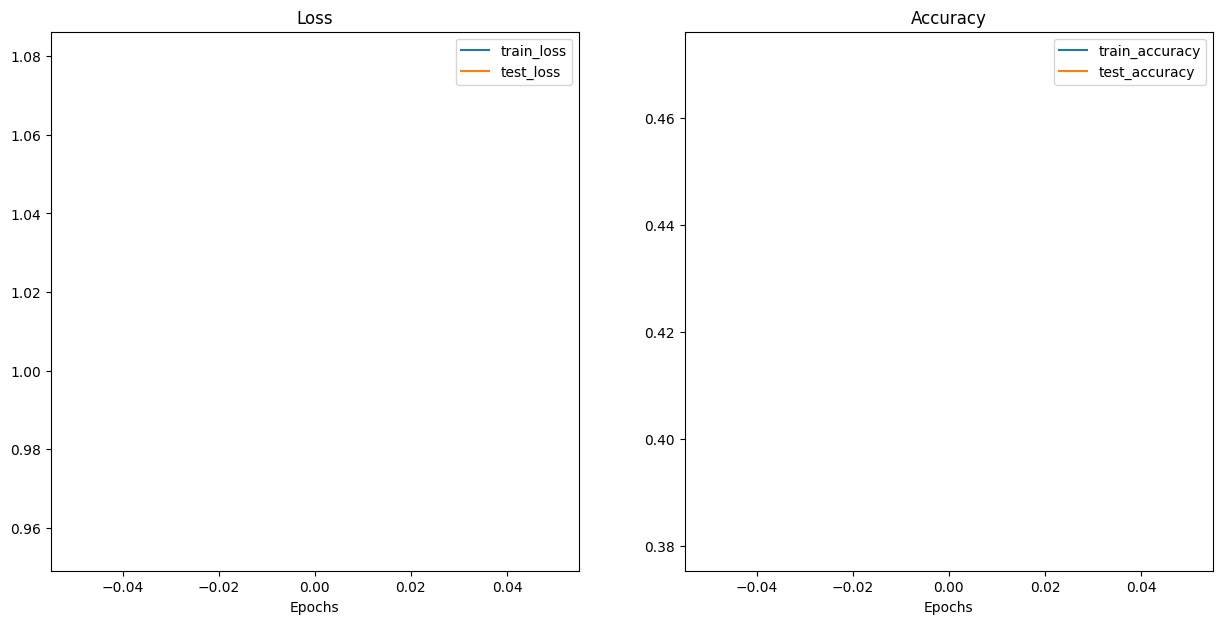

In [20]:
plot_loss_curves(loaded_result)

## Evaluace

In [21]:
image_path = Path("/content/content")

evaluate_img(loaded_model_0, image_path, class_names, device)